In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/

Mounted at /content/drive/
/content/drive/My Drive


In [ ]:
import numpy as np
import pandas as pd
data = pd.read_csv('accepted_2007_to_2018Q4.csv',parse_dates=['issue_d'], infer_datetime_format=True)
data.drop(data.tail(2).index, inplace=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
num_feat = ['acc_now_delinq','acc_open_past_24mths','all_util','annual_inc','avg_cur_bal','bc_open_to_buy','bc_util',
            'chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','dti','earliest_cr_line',
            'fico_range_high','fico_range_low','il_util','inq_fi','inq_last_12m','inq_last_6mths','installment',
            'last_fico_range_high','last_fico_range_low','max_bal_bc','mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
            'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc','mths_since_last_delinq','mths_since_last_major_derog',
            'mths_since_last_record','mths_since_rcnt_il','mths_since_recent_bc','mths_since_recent_bc_dlq',
            'mths_since_recent_inq','mths_since_recent_revol_delinq','num_accts_ever_120_pd','num_actv_bc_tl',
            'num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0',
            'num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_acc_6m',
            'open_il_12m','open_il_24m','open_rv_12m','open_rv_24m','pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec',
            'pub_rec_bankruptcies','revol_util','tot_coll_amt','tot_cur_bal','tot_hi_cred_lim','total_acc','total_bal_ex_mort',
            'total_bal_il','total_bc_limit','total_cu_tl','total_il_high_credit_limit','total_rev_hi_lim']

cat_feat = ['term','verification_status','sub_grade']

X = data[ ['issue_d'] + cat_feat + num_feat].copy()
#X.info()

# The features earliest_cr_line is date and its type should be changed to datetime. Later 
# it need to be transformed to ordinal numeric features
X['earliest_cr_line'] = pd.to_numeric(pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True))

#print(data['loan_status'].value_counts())
y = data['loan_status'].copy()
y = (~y.isin(['Current', 'Fully Paid', 'In Grace Period'])).astype('int')
y.value_counts()

del data

In [ ]:
cat_feat = X.select_dtypes('object').columns.values
print(X[cat_feat].nunique().sort_values())

X['term'].replace([' 36 months',' 60 months'], [int(0), int(1)], inplace=True)

X['verification_status'].replace(['Not Verified','Source Verified', 'Verified'], [int(0), int(1), int(2)], inplace=True)

X['sub_grade'].replace(['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5',
                        'D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5',
                        'G1','G2','G3','G4','G5'], [int(x) for x in range(35)], inplace=True)

#%%
print(X.shape)

idx = np.where(
    (X['annual_inc'] <= 250000) & (X['dti'] <= 50) & (X['open_acc'] <= 40) &
    (X['total_acc'] <= 80) & (X['revol_util'] <= 120) & (X['earliest_cr_line'] > -2E18)
    )[0]
X = X.iloc[idx]
y = y.iloc[idx]
print(X.shape)

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=0)

idx = np.where(X['issue_d'].dt.year < 2017.)[0]
X_train = X.iloc[idx].drop('issue_d', axis='columns')
y_train = y.iloc[idx]

idx = np.where( (X['issue_d'].dt.year == 2017.)&(X['issue_d'].dt.month < 8.) )[0]
X_val = X.iloc[idx].drop('issue_d', axis='columns')
y_val = y.iloc[idx]

idx = np.where( ((X['issue_d'].dt.year == 2017.)&(X['issue_d'].dt.month >= 8.))|(X['issue_d'].dt.year >= 2018.) )[0]
X_test = X.iloc[idx].drop('issue_d', axis='columns')
y_test = y.iloc[idx]

print('Training prob Bad',np.mean(y_train))
print('Validation prob Bad',np.mean(y_val))
print('Test prob Bad',np.mean(y_test))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

term                    2
verification_status     3
sub_grade              35
dtype: int64
(2260699, 75)
(2213429, 75)
Training prob Bad 0.1750958388833793
Validation prob Bad 0.12304089505846083
Test prob Bad 0.05269638093425369
(1304794, 74)
(236141, 74)
(672494, 74)


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.keras.backend.clear_session()

def _prepare_labels_logits_weights(labels, logits, weights):
    """Validates labels, logits, and weights.
    Converts inputs to tensors, checks shape compatibility, and casts dtype if
    necessary.

    Args:
      labels: A `Tensor` of shape [batch_size] or [batch_size, num_labels].

      logits: A `Tensor` with the same shape as `labels`.

      weights: Either `None` or a `Tensor` with shape broadcastable to `logits`.

    Returns:
      labels: Same as `labels` arg after possible conversion to tensor, cast, and
        reshape.

      logits: Same as `logits` arg after possible conversion to tensor and
        reshape.

      weights: Same as `weights` arg after possible conversion, cast, and reshape.

      original_shape: Shape of `labels` and `logits` before reshape.

    Raises:
      ValueError: If `labels` and `logits` do not have the same shape.
    """

    # Convert `labels` and `logits` to Tensors and standardize dtypes.
    logits = tf.convert_to_tensor(logits, name='logits')
    labels = tf.cast(tf.convert_to_tensor(labels, name='labels'), dtype=logits.dtype.base_dtype)
    weights = tf.cast(tf.convert_to_tensor(weights, name='weights'), dtype=logits.dtype.base_dtype)

    try:
        labels.get_shape().merge_with(logits.get_shape())
    except ValueError:
        raise ValueError('logits and labels must have the same shape (%s vs %s)' %
                       (logits.get_shape(), labels.get_shape()))

    original_shape = labels.get_shape().as_list()

    if labels.get_shape().ndims > 0:
        original_shape[0] = -1

    if labels.get_shape().ndims <= 1:
        labels = tf.reshape(labels, [-1, 1])
        logits = tf.reshape(logits, [-1, 1])

    if weights.get_shape().ndims == 1:
        # Weights has shape [batch_size]. Reshape to [batch_size, 1].
        weights = tf.reshape(weights, [-1, 1])

    if weights.get_shape().ndims == 0:
        # Weights is a scalar. Change shape of weights to match logits.
        weights *= tf.ones_like(logits)

    return labels, logits, weights, original_shape

def roc_auc_loss(
    labels,
    logits,
    weights=1.0,
    surrogate_type='xent',
    scope=None):

    with tf.name_scope("roc_auc"):
        # Convert inputs to tensors and standardize dtypes.
        labels, logits, weights, original_shape = _prepare_labels_logits_weights(labels, logits, weights)
        
        # Create tensors of pairwise differences for logits and labels, and
        # pairwise products of weights. These have shape
        # [batch_size, batch_size, num_labels].
        logits_difference = tf.expand_dims(logits, 0) - tf.expand_dims(logits, 1)
        labels_difference = tf.expand_dims(labels, 0) - tf.expand_dims(labels, 1)
        weights_product = tf.expand_dims(weights, 0) * tf.expand_dims(weights, 1)

        signed_logits_difference = labels_difference * logits_difference

        raw_loss = weighted_surrogate_loss(labels=tf.ones_like(signed_logits_difference),
                                           logits=signed_logits_difference,
                                           surrogate_type=surrogate_type)
        
        weighted_loss = weights_product * raw_loss

        # Zero out entries of the loss where labels_difference zero (so loss is only
        # computed on pairs with different labels).
        loss = tf.reduce_mean(tf.abs(labels_difference) * weighted_loss, 0) * 0.5
        loss = tf.reshape(loss, original_shape)
        return loss

def weighted_surrogate_loss(labels,
                            logits,
                            surrogate_type='xent',
                            positive_weights=1.0,
                            negative_weights=1.0,
                            name=None):
    """Returns either weighted cross-entropy or hinge loss.
    For example `surrogate_type` is 'xent' returns the weighted cross
    entropy loss.

    Args:
     labels: A `Tensor` of type `float32` or `float64`. Each entry must be
        between 0 and 1. `labels` can be a 2D tensor with shape
        [batch_size, num_labels] or a 3D tensor with shape
        [batch_size, num_labels, K].

      logits: A `Tensor` of the same type and shape as `labels`. If `logits` has
        shape [batch_size, num_labels, K], each slice [:, :, k] represents an
        'attempt' to predict `labels` and the loss is computed per slice.

      surrogate_type: A string that determines which loss to return, supports
      'xent' for cross-entropy and 'hinge' for hinge loss.

      positive_weights: A `Tensor` that holds positive weights and has the
        following semantics according to its shape:
          scalar - A global positive weight.
          1D tensor - must be of size K, a weight for each 'attempt'
          2D tensor - of size [num_labels, K'] where K' is either K or 1.
        The `positive_weights` will be expanded to the left to match the
        dimensions of logits and labels.

      negative_weights: A `Tensor` that holds positive weight and has the
        semantics identical to positive_weights.

      name: A name for the operation (optional).

    Returns:
      The weigthed loss.

    Raises:
      ValueError: If value of `surrogate_type` is not supported.
    """

    with tf.name_scope('weighted_loss'):
        if surrogate_type == 'xent':
            return weighted_sigmoid_cross_entropy_with_logits(
                logits=logits,
                labels=labels,
                positive_weights=positive_weights,
                negative_weights=negative_weights,
                name=name)
        elif surrogate_type == 'hinge':
            return weighted_hinge_loss(
                logits=logits,
                labels=labels,
                positive_weights=positive_weights,
                negative_weights=negative_weights,
                name=name)
        raise ValueError('surrogate_type %s not supported.' % surrogate_type) 

def weighted_sigmoid_cross_entropy_with_logits(labels,
                                               logits,
                                               positive_weights=1.0,
                                               negative_weights=1.0,
                                               name=None):
    """Computes a weighting of sigmoid cross entropy given `logits`.
    Measures the weighted probability error in discrete classification tasks in
    which classes are independent and not mutually exclusive.  For instance, one
    could perform multilabel classification where a picture can contain both an
    elephant and a dog at the same time. The class weight multiplies the
    different types of errors.
    For brevity, let `x = logits`, `z = labels`, `c = positive_weights`,
    `d = negative_weights`  The

    weighed logistic loss is
    ```
    c * z * -log(sigmoid(x)) + d * (1 - z) * -log(1 - sigmoid(x))
    = c * z * -log(1 / (1 + exp(-x))) - d * (1 - z) * log(exp(-x) / (1 + exp(-x)))
    = c * z * log(1 + exp(-x)) + d * (1 - z) * (-log(exp(-x)) + log(1 + exp(-x)))
    = c * z * log(1 + exp(-x)) + d * (1 - z) * (x + log(1 + exp(-x)))
    = (1 - z) * x * d + (1 - z + c * z ) * log(1 + exp(-x))
    =  - d * x * z + d * x + (d - d * z + c * z ) * log(1 + exp(-x))
    ```
    To ensure stability and avoid overflow, the implementation uses the identity
        log(1 + exp(-x)) = max(0,-x) + log(1 + exp(-abs(x)))

    and the result is computed as
      ```
      = -d * x * z + d * x
        + (d - d * z + c * z ) * (max(0,-x) + log(1 + exp(-abs(x))))
      ```
    Note that the loss is NOT an upper bound on the 0-1 loss, unless it is divided
    by log(2).

    Args:
      labels: A `Tensor` of type `float32` or `float64`. `labels` can be a 2D
        tensor with shape [batch_size, num_labels] or a 3D tensor with shape
        [batch_size, num_labels, K].

      logits: A `Tensor` of the same type and shape as `labels`. If `logits` has
        shape [batch_size, num_labels, K], the loss is computed separately on each
        slice [:, :, k] of `logits`.

      positive_weights: A `Tensor` that holds positive weights and has the
        following semantics according to its shape:
          scalar - A global positive weight.
          1D tensor - must be of size K, a weight for each 'attempt'
          2D tensor - of size [num_labels, K'] where K' is either K or 1.
        The `positive_weights` will be expanded to the left to match the
        dimensions of logits and labels.

      negative_weights: A `Tensor` that holds positive weight and has the
        semantics identical to positive_weights.

      name: A name for the operation (optional).

    Returns:
      A `Tensor` of the same shape as `logits` with the componentwise
        weighted logistic losses.
    """

    with tf.name_scope('weighted_logistic_loss'):
        labels, logits, positive_weights, negative_weights = prepare_loss_args(labels, logits, positive_weights, negative_weights)

        softplus_term = tf.add(tf.maximum(-logits, 0.0), tf.math.log(1.0 + tf.exp(-tf.abs(logits))))
        weight_dependent_factor = ( negative_weights + (positive_weights - negative_weights) * labels)
        return (negative_weights * (logits - labels * logits) + weight_dependent_factor * softplus_term)

def weighted_hinge_loss(labels,
                        logits,
                        positive_weights=1.0,
                        negative_weights=1.0,
                        name=None):
    """Computes weighted hinge loss given logits `logits`.
    The loss applies to multi-label classification tasks where labels are
    independent and not mutually exclusive. See also
    `weighted_sigmoid_cross_entropy_with_logits`.

    Args:
      labels: A `Tensor` of type `float32` or `float64`. Each entry must be
        either 0 or 1. `labels` can be a 2D tensor with shape
        [batch_size, num_labels] or a 3D tensor with shape
        [batch_size, num_labels, K].

      logits: A `Tensor` of the same type and shape as `labels`. If `logits` has
        shape [batch_size, num_labels, K], the loss is computed separately on each
        slice [:, :, k] of `logits`.
      
      positive_weights: A `Tensor` that holds positive weights and has the
        following semantics according to its shape:
          scalar - A global positive weight.
          1D tensor - must be of size K, a weight for each 'attempt'
          2D tensor - of size [num_labels, K'] where K' is either K or 1.
        The `positive_weights` will be expanded to the left to match the
        dimensions of logits and labels.
      
      negative_weights: A `Tensor` that holds positive weight and has the
        semantics identical to positive_weights.
      
      name: A name for the operation (optional).
    Returns:
      A `Tensor` of the same shape as `logits` with the componentwise
        weighted hinge loss.
    """

    with tf.name_scope("weighted_hinge_loss"):
        labels, logits, positive_weights, negative_weights = prepare_loss_args(labels, logits, positive_weights, negative_weights)

        positives_term = positive_weights * labels * tf.maximum(1.0 - logits, 0)
        negatives_term = (negative_weights * (1.0 - labels) * tf.maximum(1.0 + logits, 0))
        return positives_term + negatives_term

def prepare_loss_args(labels, logits, positive_weights, negative_weights):
    """Prepare arguments for weighted loss functions.
    If needed, will convert given arguments to appropriate type and shape.
    Args:
      labels: labels or labels of the loss function.
      logits: Logits of the loss function.
      positive_weights: Weight on the positive examples.
      negative_weights: Weight on the negative examples.
    Returns:
      Converted labels, logits, positive_weights, negative_weights.
    """

    logits = tf.convert_to_tensor(logits, name='logits')
    #labels = convert_and_cast(labels, 'labels', logits.dtype)
    labels = tf.cast(tf.convert_to_tensor(labels, name='labels'), dtype=logits.dtype)

    if len(labels.get_shape()) == 2 and len(logits.get_shape()) == 3:
        labels = tf.expand_dims(labels, [2])

    positive_weights = tf.cast(tf.convert_to_tensor(positive_weights, name='positive_weights'), dtype=logits.dtype)
    positive_weights = expand_outer(positive_weights, logits.get_shape().ndims)
    
    negative_weights = tf.cast(tf.convert_to_tensor(negative_weights, name='negative_weights'), dtype=logits.dtype)
    negative_weights = expand_outer(negative_weights, logits.get_shape().ndims)
    return labels, logits, positive_weights, negative_weights

def expand_outer(tensor, rank):
    """Expands the given `Tensor` outwards to a target rank.
    For example if rank = 3 and tensor.shape is [3, 4], this function will expand
    to such that the resulting shape will be  [1, 3, 4].
    Args:
      tensor: The tensor to expand.
      rank: The target dimension.
    Returns:
      The expanded tensor.
    Raises:
      ValueError: If rank of `tensor` is unknown, or if `rank` is smaller than
        the rank of `tensor`.
    """

    if tensor.get_shape().ndims is None:
        raise ValueError('tensor dimension must be known.')
    if len(tensor.get_shape()) > rank:
        raise ValueError('`rank` must be at least the current tensor dimension: (%s vs %s).' % (rank, len(tensor.get_shape())))
    while len(tensor.get_shape()) < rank:
        tensor = tf.expand_dims(tensor, 0)
    return tensor

class BatchNormFCLayer(tf.keras.layers.Layer):  # for the case of fully connected (1D inputs)
    """
    We create class variables such as gamma and beta to be trained. Also creating pop_mean and pop_var
    that are expected to grow up to obtain estimates for the population mean and population variance.
    The exponential moving average is simple and lets us avoid extra work than moving average.
    It is known that the α of the EMA is associated with window length n like this: α =2/(n+1)
    """
    def __init__(self, decay = 0.999, epsilon=0.00000001):
        """
        :param epsilon:
        :param decay:
        """
        super().__init__()
        gamma_init = tf.ones_initializer()
        self.gamma = tf.Variable(initial_value=gamma_init(shape=[1], dtype='float32'), trainable=True)
       
        beta_init = tf.zeros_initializer()
        self.beta = tf.Variable(initial_value=beta_init(shape=[1], dtype='float32'), trainable=True)
       
        self.decay = decay
        self.epsilon = epsilon
    """
    In general, we might need to know the shape of the input before runtime in which case we can implement
    the build() method in our layer which takes input_shape as a parameter and is called when we compile.
    """
    def build(self, input_shape):  # should pass shape for our variable
        self.pop_mean = tf.Variable(tf.zeros([input_shape[-1]]), trainable=False)
        self.pop_var = tf.Variable(tf.ones([input_shape[-1]]), trainable=False)
        super().build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, mask=None, training=None):  # Defines the computation from inputs to outputs
        """
        DON'T USE 'training=True' when built by Functional API. If doing that then we force the layer be in
        the training mode even during the inference.
        Example:
        inputs = tf.keras.Input(shape=(10))
        x = tf.keras.layers.Dropout(rate=0.5)(inputs, training=True) #<- take training=True out makes inference correct
        model = tf.keras.Model(inputs=inputs,outputs=x)
        model.predict(tf.constant([1]*10))
        """
        if mask is None:
            mask = tf.ones_like(inputs)
        prob_mask = tf.math.divide_no_nan(mask, tf.math.reduce_sum( mask, axis=0 ))  # Mask: real value = 1, NaN value = 0

        mu = tf.math.reduce_sum( tf.math.multiply_no_nan(inputs, prob_mask) , axis=0 )
        variance = tf.math.reduce_sum( tf.math.multiply_no_nan( inputs**2, prob_mask) , axis=0 ) - mu ** 2

        if training:  # In case of training, perform batch normalization to learn beta and gamma
            self.pop_mean.assign( self.pop_mean * self.decay + mu * (1 - self.decay) )
            self.pop_var.assign( self.pop_var * self.decay + variance * (1 - self.decay) )
            #outputs = tf.nn.batch_normalization(inputs, mu, variance, self.beta, self.gamma, K.epsilon())
            x_hat = (inputs - mu)/tf.sqrt(tf.maximum(variance, K.epsilon()))
           
        else:  # In case of testing - calculation of the inference model
            #outputs = tf.nn.batch_normalization(inputs, self.pop_mean, self.pop_var, self.beta, self.gamma, K.epsilon())
            x_hat = (inputs - self.pop_mean)/tf.sqrt(tf.maximum(self.pop_var, K.epsilon()))
           
        x_hat = tf.math.multiply_no_nan(x_hat, mask) # put non-real value to zeros
        outputs = self.gamma * x_hat + self.beta # + (mask-1)*9 # replace non-real value
        return outputs

class GBN(tf.keras.layers.Layer):
    """
    Ghost Batch Normalization
    https://arxiv.org/abs/1705.08741
    """
    def __init__(self, batch_size, virtual_batch_size, decay=0.999):
        super(GBN, self).__init__()
        self.batch_size = batch_size
        self.virtual_batch_size = virtual_batch_size
        self.num_splits = int(np.ceil(self.batch_size / self.virtual_batch_size))
        self.bn = BatchNormFCLayer(decay)
    
    def build(self, input_shape):
        self.bn.build(input_shape)
        super().build(input_shape)

    def call(self, inputs, mask=None, training=None):
        if tf.math.floor(tf.shape(inputs)[0] / self.virtual_batch_size)< self.num_splits:
            if mask is None:
                res = self.bn(inputs, None, training)
            else:
                res = self.bn(inputs, mask, training)
            output = res
        else:
            inp_chunks = tf.split(inputs, self.num_splits, axis=0)
            if mask is None:
                res = [self.bn(x_, None, training) for x_ in inp_chunks]
            else:
                mask_chunks = tf.split(mask, self.num_splits, axis=0)
                res = [self.bn(x_, m_, training) for x_, m_ in zip(inp_chunks, mask_chunks)]
            output = tf.concat(res, axis=0)
        
        return output

def scaled_dot_product_attention(q, k, v, mask=None):
    """Calculate the attention weights.
    Args:
        q: query shape == [..., seq_len_q, depth]
        k: key shape == [..., seq_len_k, depth]
        v: value shape == [..., seq_len_v, depth_v]
        mask: Float tensor with shape broadcastable to [..., seq_len_q, seq_len_k].
    
    Returns:
        output, attention_weights
    """
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # [..., seq_len_q, seq_len_k]
    output = tf.matmul(attention_weights, v)  # [..., seq_len_q, depth_v]
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, output_dim):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(output_dim)
    
    def split_heads(self, x, batch_size):
        """Split the last dimension into [num_heads, depth].
        Transpose the result such that the shape is [batch_size, num_heads, seq_len, depth]
        """
        # [batch_size, seq_len, num_heads, depth]
        x = tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.depth)) 
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]  # q.shape: [batch_size, seq_len, d_model]
        
        q = self.wq(q)  # [batch_size, seq_len, d_model]
        k = self.wk(k)  # [batch_size, seq_len, d_model]
        v = self.wv(v)  # [batch_size, seq_len, d_model]
        
        q = self.split_heads(q, batch_size)  # [batch_size, num_heads, seq_len_q, depth]
        k = self.split_heads(k, batch_size)  # [batch_size, num_heads, seq_len_k, depth]
        v = self.split_heads(v, batch_size)  # [batch_size, num_heads, seq_len_v, depth]
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention.shape == [batch_size, num_heads, seq_len_q, depth]
        # attention_weights.shape == [batch_size, num_heads, seq_len_q, seq_len_k]
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        # [batch_size, seq_len_q, num_heads, depth]
        concat_attention = tf.reshape(scaled_attention, shape=(batch_size, -1, self.d_model)) 
        # [batch_size, seq_len_q, d_model]
        
        output = self.dense(concat_attention)  # [batch_size, seq_len_q, output_dim]
        return output, attention_weights

import enum
import math
class _TokenInitialization(enum.Enum):
    UNIFORM = 'uniform'
    NORMAL = 'normal'

    @classmethod
    def from_str(cls, initialization: str) -> '_TokenInitialization':
        try:
            return cls(initialization)
        except ValueError:
            valid_values = [x.value for x in _TokenInitialization]
            raise ValueError(f'initialization must be one of {valid_values}')
    
    def apply(self, n_features: int, d_token: int) -> tf.Variable:
        d_sqrt_inv = 1 / math.sqrt(d_token)
        if self == _TokenInitialization.UNIFORM:
            # used in the paper "Revisiting Deep Learning Models for Tabular Data";
            # is equivalent to `nn.init.kaiming_uniform_(x, a=math.sqrt(5))` (which is
            # used by torch to initialize nn.Linear.weight, for example)
            initializer = tf.random_uniform_initializer(minval=-d_sqrt_inv, maxval=d_sqrt_inv)
            return tf.Variable(initial_value=initializer(shape=(n_features, d_token), dtype="float32"),trainable=True,)
            #nn.init.uniform_(x, a=-d_sqrt_inv, b=d_sqrt_inv)
        elif self == _TokenInitialization.NORMAL:
            #nn.init.normal_(x, std=d_sqrt_inv)
            initializer = tf.random_normal_initializer(stddev=d_sqrt_inv)
            return tf.Variable(initial_value=initializer(shape=(n_features, d_token), dtype="float32"),trainable=True,)

class NumericalFeatureTokenizer(tf.keras.layers.Layer):
    def __init__(
            self,
            n_features: int,
            d_token: int,
            bias: bool,
            initialization: str,
            ) -> None:
        super(NumericalFeatureTokenizer, self).__init__()
        
        initialization_ = _TokenInitialization.from_str(initialization)
        
        self.weight = initialization_.apply(n_features, d_token)
        self.bias = initialization_.apply(n_features, d_token) if bias else None
    
    @property
    def n_tokens(self) -> int:
        """The number of tokens."""
        return self.weight.shape[0]

    @property
    def d_token(self) -> int:
        """The size of one token."""
        return self.weight.shape[1]
    
    def call(self, x):
        x = self.weight[None] * x[..., None]
        if self.bias is not None:
            x = x + self.bias[None]
        return x

from typing import List
class CategoricalFeatureTokenizer(tf.keras.layers.Layer):    
    def __init__(
            self,
            cardinalities: List[int],
            d_token: int,
            bias: bool,
            initialization: str,
            ) -> None:
        super(CategoricalFeatureTokenizer, self).__init__()
        
        assert cardinalities, 'cardinalities must be non-empty'
        assert d_token > 0, 'd_token must be positive'
        initialization_ = _TokenInitialization.from_str(initialization)

        self.category_offsets = tf.Variable(tf.cast(tf.cumsum([0]+cardinalities[:-1], axis=0),"float32"), trainable=False)
        self.embeddings = tf.keras.layers.Embedding(sum(cardinalities), d_token, 
                                                    embeddings_regularizer=tf.keras.regularizers.L1(0.05),
                                                    embeddings_initializer=initialization)
        #self.embeddings = tf.keras.layers.Embedding(sum(cardinalities), d_token, embeddings_initializer=tf.keras.initializers.Orthogonal)
        self.bias = initialization_.apply(len(cardinalities), d_token) if bias else None
    
    @property
    def n_tokens(self) -> int:
        """The number of tokens."""
        return self.category_offsets.shape[0]

    @property
    def d_token(self) -> int:
        """The size of one token."""
        return self.embeddings.output_dim
    
    def call(self, x):
        x = self.embeddings(x + self.category_offsets[None])
        if self.bias is not None:
            x = x + self.bias[None]
        return x

In [ ]:
class EncBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, d_model, num_heads, ff_dim, rate=0.):
        super(EncBlock, self).__init__()
        #self.att = MultiHeadAttention(d_model=d_model, num_heads=num_heads, output_dim=embed_dim)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=rate)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="leaky_relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        #attn_output, _ = self.att(inputs, inputs, inputs)
        attn_output = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

VARLEN = X_train.shape[1] # Variable size for each sample
EMBED_DIM = 16
D_MODEL = 16
NUM_HEADS = 1  # Number of attention heads
FF_DIM = 16
DECAY = 0.999
BATCH_SIZE = 2048
VIRTUAL_BATCH = 32

CARDINALITIES = [2 for _ in range(VARLEN)] # category size for each variable

inputs = tf.keras.layers.Input(shape=(VARLEN))
mask = tf.where( tf.math.is_nan(inputs), 0., 1. ) # w/ real value = 1, w/o real value = 0
#n_token = tf.expand_dims(BatchNormFCLayer(decay=DECAY)(inputs, mask), -1)
#c_token = CategoricalFeatureTokenizer(CARDINALITIES, EMBED_DIM-1, True, 'uniform')(mask)

#n_token = BatchNormFCLayer(decay=DECAY)(inputs, mask)
n_token = GBN(BATCH_SIZE, VIRTUAL_BATCH, decay=DECAY)(inputs, mask)
n_token = NumericalFeatureTokenizer(VARLEN, 8, True, 'uniform')(n_token)
c_token = CategoricalFeatureTokenizer(CARDINALITIES, EMBED_DIM-8, True, 'uniform')(mask)
x = tf.concat([n_token, c_token], axis=2)

x = EncBlock(EMBED_DIM, D_MODEL, NUM_HEADS, FF_DIM)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(32, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(4, activation="leaky_relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)
outputs = tf.keras.layers.Dense(1, activation="linear")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True),
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=roc_auc_loss,
              metrics=[tf.keras.metrics.AUC(from_logits=True)])

import tempfile
tempdir = tempfile.TemporaryDirectory()
checkpoint_filepath = f"{tempdir.name}/_test/ckp"

hist = model.fit(X_train,
                 y_train,
                 validation_data = (X_val,
                                    y_val),
                 epochs = 30,
                 batch_size = BATCH_SIZE,
                 shuffle = True,
                 callbacks=[
                     tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_loss',verbose=0,mode='min',save_best_only=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=0.00001),
                     tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
                 ] )

model.load_weights( tf.train.latest_checkpoint( f"{tempdir.name}/_test" ) )
tempdir.cleanup()

Epoch 1/30
638/638 [==============================] - 66s 51ms/step - loss: 0.0771 - auc: 0.9223 - val_loss: 0.0200 - val_auc: 0.9550 - lr: 0.0010
Epoch 2/30
638/638 [==============================] - 30s 46ms/step - loss: 0.0319 - auc: 0.9295 - val_loss: 0.0186 - val_auc: 0.9566 - lr: 0.0010
Epoch 3/30
638/638 [==============================] - 29s 46ms/step - loss: 0.0311 - auc: 0.9316 - val_loss: 0.0190 - val_auc: 0.9570 - lr: 0.0010
Epoch 4/30
638/638 [==============================] - 30s 47ms/step - loss: 0.0308 - auc: 0.9327 - val_loss: 0.0188 - val_auc: 0.9569 - lr: 0.0010
Epoch 5/30
638/638 [==============================] - 30s 47ms/step - loss: 0.0275 - auc: 0.9335 - val_loss: 0.0154 - val_auc: 0.9569 - lr: 5.0000e-04
Epoch 6/30
638/638 [==============================] - 30s 46ms/step - loss: 0.0272 - auc: 0.9340 - val_loss: 0.0153 - val_auc: 0.9572 - lr: 5.0000e-04
Epoch 7/30
638/638 [==============================] - 29s 46ms/step - loss: 0.0270 - auc: 0.9342 - val_loss: 0

In [ ]:
from sklearn.metrics import roc_auc_score
y_pred = tf.nn.sigmoid(model.predict(X_train, batch_size=BATCH_SIZE))
roc_auc = roc_auc_score( y_train, y_pred )
print("Train",roc_auc)
print(np.mean(y_pred))
print("")

y_pred = tf.nn.sigmoid(model.predict(X_val, batch_size=BATCH_SIZE))
roc_auc = roc_auc_score( y_val, y_pred )
print("Validation",roc_auc)
print(np.mean(y_pred))
print("")

y_pred = tf.nn.sigmoid(model.predict(X_test, batch_size=BATCH_SIZE))
roc_auc = roc_auc_score( y_test, y_pred )
print("Testing",roc_auc)
print(np.mean(y_pred))
print("")

638/638 [==============================] - 10s 13ms/step
Train 0.9440108752737824
0.46309718

116/116 [==============================] - 2s 14ms/step
Validation 0.9576556231709001
0.3877081

329/329 [==============================] - 4s 13ms/step
Testing 0.9390306794161319
0.30412868



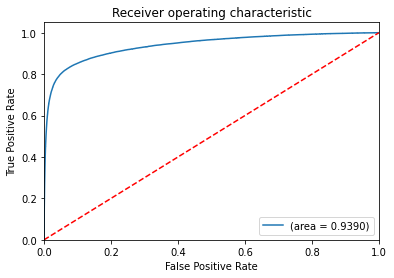

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
False_positive_rate, Recall, thresholds = roc_curve( y_test, y_pred )

plt.figure()
plt.plot(False_positive_rate, Recall, label='(area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def find_best_threshold(threshould, fpr, tpr):
   #optimal_idx = np.argmax(tpr - fpr)
   optimal_idx = np.argmax(tpr*(1-fpr))
   optimal_threshold = threshould[optimal_idx]
   # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
   print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(optimal_threshold,3))
   return optimal_threshold
THRESHOLD = find_best_threshold(thresholds, False_positive_rate, Recall)
print(THRESHOLD)

the maximum value of tpr*(1-fpr) 0.7701510568245399 for threshold 0.709
0.7093551


Accuracy (test): 0.918
Precision (test): 0.375
Recall (test): 0.835


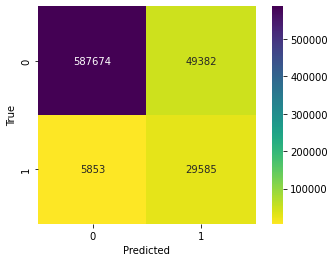

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
import seaborn as sns

y_pred_test = (y_pred.numpy() > THRESHOLD).astype('float')

acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test)
rec_test = recall_score(y_test, y_pred_test)
print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}''')

cm = confusion_matrix(y_test, y_pred_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

In [ ]:
#model.save_weights('/checkpoints/my_checkpoint')

In [ ]:
#!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
#!jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/CS395T/NN.ipynb'